## `ConvLSTM` Exploration
* the aim of this notebook is to **train** and **validate** a `ConvLSTM()`,  exploring different setups.

In [1]:
import os
from pathlib import Path
from typing import Any, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from livelossplot import PlotLosses
from matplotlib.colors import ListedColormap
from scipy import io
from torch.utils.data import DataLoader
from tqdm import tqdm

from rainnow.src.conv_lstm_utils import (
    IMERGDataset,
    plot_predicted_sequence,
    save_checkpoint,
    train,
    validate,
    create_eval_loader,
)
from rainnow.src.loss import CBLoss, LPIPSMSELoss
from rainnow.src.models.conv_lstm import ConvLSTMModel
from rainnow.src.normalise import PreProcess
from rainnow.src.utilities.loading import load_imerg_datamodule_from_config
from rainnow.src.utilities.utils import (
    get_device,
    transform_0_1_to_minus1_1,
    transform_minus1_1_to_0_1,
)

#### `helpers.`

In [2]:
# ** plotting helpers **
cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
# cmap = io.loadmat("/teamspace/studios/this_studio/irp-ds423/rainnow/src/utilities/cmaps/colormap.mat")
rain_cmap = ListedColormap(cmap["Cmap_rain"])
global_params = {"font.size": 8}  # , "font.family": "Times New Roman"}
plt_params = {"wspace": 0.1, "hspace": 0.15}
ylabel_params = {"ha": "right", "va": "bottom", "labelpad": 1, "fontsize": 7.5}

# ** get device **
device = get_device()

No GPU available! (device = cpu)


#### `Datasets & Dataloaders`

In [3]:
# ** DIR helpers **
CKPT_BASE_PATH = "/Users/ds423/git_uni/irp-ds423/rainnow/results/"
CONFIGS_BASE_PATH = "/Users/ds423/git_uni/irp-ds423/rainnow/src/dyffusion/configs/"
# CKPT_BASE_PATH = "/teamspace/studios/this_studio/irp-ds423/rainnow/results/"
# CONFIGS_BASE_PATH = "/teamspace/studios/this_studio/irp-ds423/rainnow/src/dyffusion/configs/"

CKPT_DIR = "checkpoints"
CKPT_CFG_NAME = "hparams.yaml"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"
# whether or not to get last.ckpt or to get the "best model" ckpt (the other one in the folder).
GET_LAST = False

# ** Dataloader Params **
BATCH_SIZE = 12
NUM_WORKERS = 0

INPUT_SEQUENCE_LENGTH = 4
OUTPUT_SEQUENCE_LENGTH = 1

In [4]:
datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    overrides={
        # "boxes": ["1,0"],
        "boxes": ["0,0", "1,0", "2,0", "2,1"],
        "window": 1,
        "horizon": 8,
        "prediction_horizon": 8,
        "sequence_dt": 1,
    },
)

# get the .data_<split>
datamodule.setup("train")
datamodule.setup("validate")

[2024-08-29 11:27:44][imerg_precipitation.py][INFO] --> training, validation & test using 4 (i, j) boxes: ['0,0', '1,0', '2,0', '2,1'].
[2024-08-29 11:27:44][imerg_precipitation.py][INFO] --> train data split: [None, 202301010000]


[2024-08-29 11:28:24][torch_datasets.py][INFO] --> creating TRAIN tensor dataset.
[2024-08-29 11:28:25][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-29 11:28:34][imerg_precipitation.py][INFO] --> training, validation & test using 4 (i, j) boxes: ['0,0', '1,0', '2,0', '2,1'].
[2024-08-29 11:28:34][imerg_precipitation.py][INFO] --> validate data split: [202301010000, 202307010000]
[2024-08-29 11:28:44][torch_datasets.py][INFO] --> creating VAL tensor dataset.
[2024-08-29 11:28:45][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


In [5]:
# create the datasets.
train_dataset = IMERGDataset(
    datamodule, "train", sequence_length=INPUT_SEQUENCE_LENGTH, target_length=OUTPUT_SEQUENCE_LENGTH
)
val_dataset = IMERGDataset(
    datamodule, "validate", sequence_length=INPUT_SEQUENCE_LENGTH, target_length=OUTPUT_SEQUENCE_LENGTH
)

# instantiate the dataloaders.
train_loader = DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
)

In [6]:
# ** instantiate the preprocesser obj **
pprocessor = PreProcess(
    percentiles=datamodule.normalization_hparams["percentiles"],
    minmax=datamodule.normalization_hparams["min_max"],
)

[2024-08-29 11:28:46][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


####  `Training and Val:`

##### `Loss Function(s)`

In [7]:
## ** loss function

# criterion = nn.MSELoss(reduction='mean')
# criterion = nn.L1Loss(reduction='mean')
# criterion = nn.BCELoss(reduction="mean")
# criterion = CBLoss(beta=1.0, data_preprocessor_obj=pprocessor)
criterion = LPIPSMSELoss(
    alpha=0.6,
    model_name="alex",  # trains better with 'alex' - https://github.com/richzhang/PerceptualSimilarity.
    reduction="mean",
    gamma=1.0,
    mse_type="cb",
    **{"beta": 1, "data_preprocessor_obj": pprocessor},
).to(device)

##### `Instantiate a ConvLSTM()`

In [8]:
# ** instantiate a new model **

KERNEL_SIZE = (5, 5)
INPUT_DIMS = (1, 128, 128)  # C, H, W
OUTPUT_CHANNELS = 1
HIDDEN_CHANNELS = [128, 128]
NUM_LAYERS = 2
CELL_DROPOUT = 0.15
OUTPUT_ACTIVATION = nn.Tanh()

model = ConvLSTMModel(
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
    input_dims=INPUT_DIMS,
    hidden_channels=HIDDEN_CHANNELS,
    output_channels=OUTPUT_CHANNELS,
    num_layers=NUM_LAYERS,
    kernel_size=KERNEL_SIZE,
    output_activation=OUTPUT_ACTIVATION,
    apply_batchnorm=True,
    cell_dropout=CELL_DROPOUT,
    bias=True,
    device=device,
)

model = model.to(device)

In [9]:
# leave  train and validate functions here to degus more easily.
# mainly need to ensure the loss is being done on the correct dims.


def train(
    model: nn.Module,
    device: str,
    data_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    tepoch: tqdm,
    curr_epoch: int,
    n_epochs: int,
    log_training: bool = True,
) -> float:
    model.train()
    train_loss = 0.0
    for batch_idx, (X, y) in enumerate(data_loader, start=1):
        X, y = X.to(device), y.to(device)

        # transform y to X range.
        if isinstance(model.output_activation, nn.Tanh):
            y = transform_0_1_to_minus1_1(y)

        optimizer.zero_grad()
        pred = model(X)

        # for LPIPS, I need to get it in form N, C, H, W.
        loss = criterion(pred.reshape(-1, 1, 128, 128), y.reshape(-1, 1, 128, 128))
        # loss = criterion(pred, y)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if log_training:
            tepoch.set_description(
                f"Epoch: {curr_epoch}/{n_epochs} | Batch: {batch_idx}/{len(data_loader)}"
            )
            tepoch.set_postfix(loss=loss.item() / X.size(0), refresh=False)
            tepoch.update()

    return train_loss / len(data_loader.dataset)


def validate(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    device: str,
) -> float:
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # transform y to X range.
            if isinstance(model.output_activation, nn.Tanh):
                y = transform_0_1_to_minus1_1(y)

            pred = model(X)

            # for LPIPS, I need to get it in form N, C, H, W.
            loss = criterion(pred.reshape(-1, 1, 128, 128), y.reshape(-1, 1, 128, 128))
            # loss = criterion(pred, y)

            val_loss += loss.item()

    return val_loss / len(data_loader.dataset)

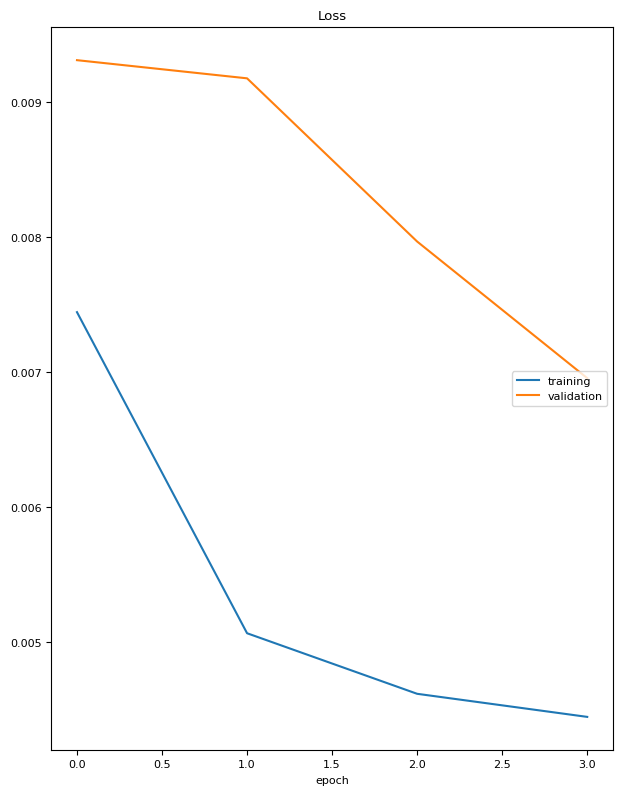

Loss
	training         	 (min:    0.004, max:    0.007, cur:    0.004)
	validation       	 (min:    0.007, max:    0.009, cur:    0.007)


Epoch: 3/4 | Batch: 1123/1123: 100%|██████████| 4492/4492 [47:07<00:00,  1.59batch/s, loss=0.00866]


In [62]:
## ** training params 101 **
n_epochs = 4
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
use_liveloss = True

# model ckpt save path.
model_save_path = f"conv_lstm_hc_{''.join([str(i) for i in HIDDEN_CHANNELS])}_ks_{KERNEL_SIZE[0]}_oa_{str(OUTPUT_ACTIVATION)[:-2]}_dummy.pt"

liveloss = PlotLosses()
train_losses, val_losses = [], []
with tqdm(total=len(train_loader) * n_epochs, desc="Training", unit="batch") as tepoch:
    for i in range(n_epochs):
        logs = {}
        train_loss = train(
            model=model,
            optimizer=optimizer,
            data_loader=train_loader,
            criterion=criterion,
            tepoch=tepoch,
            curr_epoch=i,
            n_epochs=n_epochs,
            device=device,
            log_training=True,
        )
        train_losses.append(train_loss)
        logs["loss"] = train_loss

        if val_loader:
            val_loss = validate(
                model=model,
                data_loader=val_loader,
                device=device,
                criterion=criterion,
            )
            val_losses.append(val_loss)
            logs["val_loss"] = val_loss

        if use_liveloss:
            liveloss.update(logs)
            liveloss.send()

        # save a model checkpoint.
        if model_save_path:
            # save 'best' val loss checkpoint.
            if val_loss <= min(val_losses, default=float("inf")):
                save_checkpoint(
                    model_weights=model.state_dict(),
                    optimizer_info=optimizer.state_dict(),
                    model_save_path=model_save_path,
                    epoch=i,
                    train_loss=train_loss,
                    val_loss=val_loss,
                )

    # save the last epoch.
    save_checkpoint(
        model_weights=model.state_dict(),
        optimizer_info=optimizer.state_dict(),
        model_save_path=model_save_path[:-3] + "_v2_last.pt",
        epoch=i,
        train_loss=train_loss,
        val_loss=val_loss,
    )

#### `create Predict dataloader`

In [11]:
datamodule.setup("predict")

predict_dataset = IMERGDataset(
    datamodule, "predict", sequence_length=INPUT_SEQUENCE_LENGTH, target_length=OUTPUT_SEQUENCE_LENGTH
)
predict_loader = DataLoader(
    dataset=predict_dataset, batch_size=6, num_workers=NUM_WORKERS, shuffle=False
)

[2024-08-29 11:29:30][imerg_precipitation.py][INFO] --> training, validation & test using 4 (i, j) boxes: ['0,0', '1,0', '2,0', '2,1'].
[2024-08-29 11:29:30][imerg_precipitation.py][INFO] --> predict data split: [202303070000, 202303100000]
[2024-08-29 11:29:34][torch_datasets.py][INFO] --> creating PREDICT tensor dataset.
[2024-08-29 11:29:34][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-29 11:29:35][abstract_datamodule.py][INFO] -->  Dataset predict size: 53


#### `Eval predictions`

In [14]:
# ** create the eval dataloader **
eval_loader, _ = create_eval_loader(
    data_loader=predict_loader, horizon=8, input_sequence_length=4, img_dims=(128, 128)
)

** eval loader (INFO) **
Num samples = 64 w/ dims: torch.Size([12, 1, 128, 128])



In [15]:
results = []
with torch.no_grad():
    for e, (X, target) in enumerate(eval_loader):
        predictions = {}
        # predict t+1
        _input = X.clone().unsqueeze(0).to(device)

        for t in range(target.size(0)):
            pred = model(_input)
            if isinstance(model.output_activation, nn.Tanh):
                pred = transform_minus1_1_to_0_1(pred)

            predictions[f"t{t+1}"] = pred.squeeze(0)

            # update the inputs with the last pred.
            _input = torch.concat([_input[:, 1:, ...], pred], dim=1)

        results.append([target, predictions])

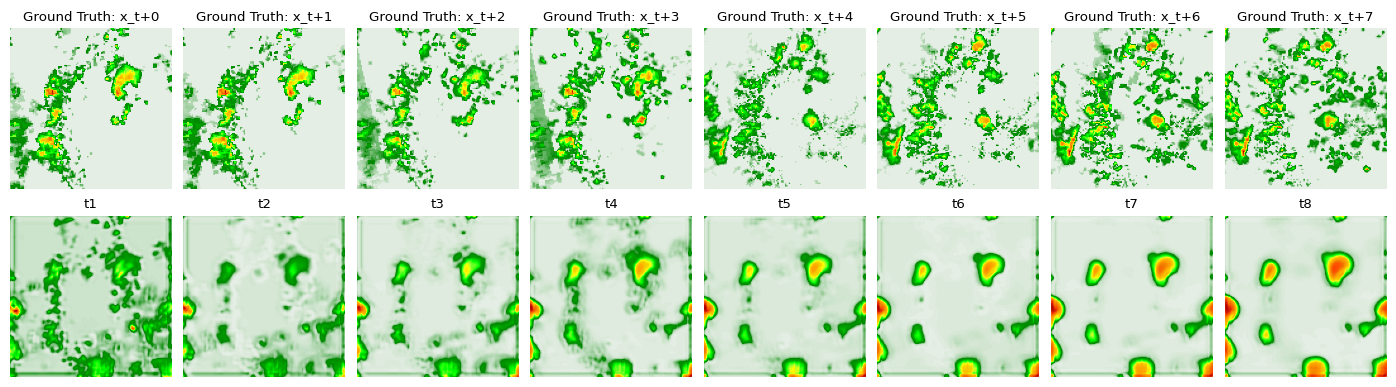

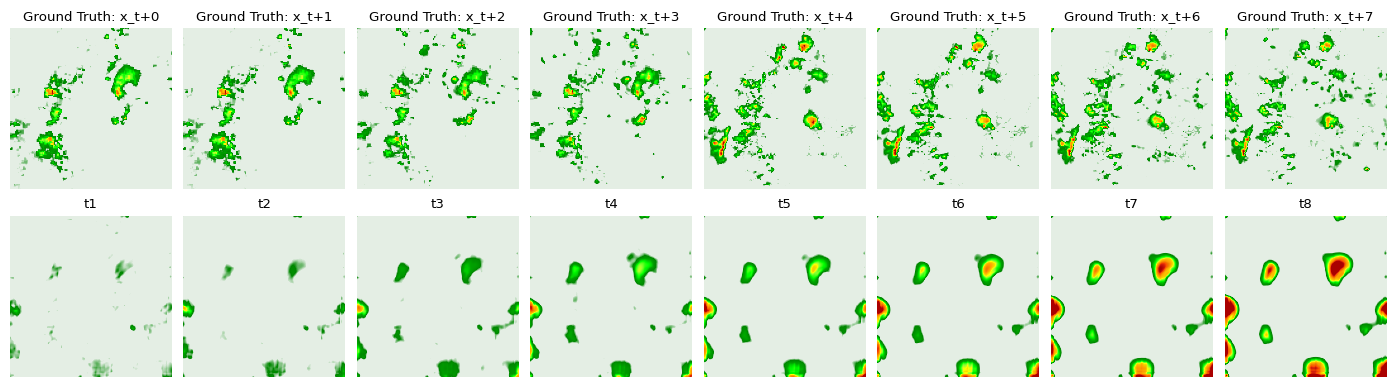

In [67]:
c = 0
figsize = (14, 4)
plot_params = {"cmap": rain_cmap, "vmin": 0.5, "vmax": 18}

idx = 13
targets, predictions = results[idx]

targets = targets.cpu().detach()
predictions = {k: v.cpu().detach() for k, v in predictions.items()}

# get raw scale.
target_reversed = pprocessor.reverse_processing(targets)
preds_reversed = {k: pprocessor.reverse_processing(v) for k, v in predictions.items()}

fig, axs = plt.subplots(2, targets.size(0), figsize=figsize)
plt.rcParams.update(global_params)
# plot ground truth in the 1st row.
for j in range(targets.size(0)):
    axs[0, j].imshow(targets[j, c, ...], **{"cmap": rain_cmap})
    axs[0, j].set_title(f"Ground Truth: x_t+{j}")
# plot predictions.
for e, (k, pred) in enumerate(predictions.items()):
    axs[1, e].imshow(pred[0, c, :, :], **{"cmap": rain_cmap})
    axs[1, e].set_title(f"{k}")
for ax in axs.flatten():
    ax.axis("off")
plt.tight_layout()

# raw scale.
fig, axs = plt.subplots(2, targets.size(0), figsize=figsize)
plt.rcParams.update(global_params)
# plot ground truth in the 1st row.
for j in range(targets.size(0)):
    axs[0, j].imshow(target_reversed[j, c, ...], **plot_params)
    axs[0, j].set_title(f"Ground Truth: x_t+{j}")
# plot predictions.
for e, (k, pred) in enumerate(preds_reversed.items()):
    axs[1, e].imshow(pred[0, c, :, :], **plot_params)
    axs[1, e].set_title(f"{k}")
for ax in axs.flatten():
    ax.axis("off")
plt.tight_layout()

### END OF SCRIPT.